## __Control Node 2.0__ 🤖
#### _Mission IGVC 2023_

<font size="2">

Node execution sequence:
- igvc_self_drive_gazebo load_task_world.launch - launches world (arena)
- roslaunch igvc_self_drive_gazebo spawn_gem.launch - launches car
- rosrun igvc_self_drive_gazebo lane_det2.py - lane detection by cv
- roslaunch point_cloud_to_laserscan point_cloud_to_laserscan.launch - point cloud to laser scan done by localisation
- roslaunch gridmap fusion - produces gridmap by fusing inputs from cv and localisation
- roslaunch hybrid_astar manual.launch - path planner execution
- rosrun velocity_plan vel_arr_basic - velocity planner execution
- rosrun nmpc control_node2.py

Note:
- run 'jupytext --sync control_node2.ipynb' everytime after saving

##### Package Imports

In [1]:
#!/usr/bin/env python
from io import StringIO
import numpy as np
import sys
import os
import do_mpc
from do_mpc.data import *
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pickle
from casadi import *
sys.path.append('../../')
rospy.init_node('control_node')
import rospy
from std_msgs.msg import Float64MultiArray
from std_msgs.msg import Float32
# from geometry_msgs.msg import PoseStamped
# from nav_msgs.msg import OccupancyGrid
from nav_msgs.msg import Path
from std_msgs.msg import String
from std_msgs.msg import Bool
from nav_msgs.msg import Path
from std_msgs.msg import UInt8
from std_msgs.msg import Float64
from geometry_msgs.msg import Point
from geometry_msgs.msg import Pose2D
from sensor_msgs.msg import Imu
from gazebo_msgs.msg import ModelStates

NameError: name 'rospy' is not defined

##### Model variables

In [2]:
# Model variables
model_type = 'continuous'
global J, La, Lb, m, Cy, t_s, N, N_ref
J = 375            # moment of interia
La = 1.2           # distance of front tires from COM in m
Lb = 1.2           # distance of back tires from COM in m
m = 200            # mass of vehicle in kg
Cy = 0.1           # Tyre stiffness constant
t_s = 0.1          # sample time
N = 70             # Horizon
N_ref = 30         # control iterations

##### Control variables

In [3]:
# variables for control execution
global velocities, path_points, c, packed, x_0, v_0, steer_0, z_sim
global conversion_matrix_x, conversion_matrix_y, conversion_matrix_v
velocities = [1.5]                                         # array to store velocities
path_points = []                                           # array to store the path
c = 1
packed = [velocities, c]
x_initial = np.vstack(([0], [0], [0], [1.5], [0], [0], [0]))   # intial state vector
x_0 = x_initial
v_0 = 0
steer_0 = 0	                                               # variable to store the curent state vector 
z_sim = 0

conversion_matrix_x = np.zeros((8,1))
conversion_matrix_y = np.zeros((8,1))
conversion_matrix_v = np.zeros((8,1))

##### ROS variables

In [ ]:
# ROS variables
acc_pub = rospy.Publisher('/throttle_cmd', Float64, queue_size=10)
brake_pub = rospy.Publisher('/brake_cmd', Float64, queue_size=10)
steer_pub = rospy.Publisher('/steer_cmd', Float64, queue_size=10)
gear_pub = rospy.Publisher('/gear_cmd', UInt8, queue_size=10)
rate = rospy.Rate(10)
path_sub = rospy.Subscriber("/path", Path, path_callback)
vel_sub = rospy.Subscriber("/best_velocity", Float64MultiArray,vel_callback)
state_sub = rospy.Subscriber("/gazebo/model_states", ModelStates, state_callback)
steer_sub = rospy.Subscriber("/current_steer_angle", Float64, steer_callback)

NameError: name 'rospy' is not defined

: 

##### Functions for interpolation of MP path points

In [ ]:
def linear_regression(x, n=0, lamda=0):
        n = len(x)
        z0 = np.array([1 for i in range(n)])
        z1 = np.array([i+1 for i in range(n)])
        z2 = z1**2
        z3 = z1**3
        z4 = z1**4
        z5 = z1**5
        z6 = z1**6
        z7 = z1**7
        z = np.vstack((z0, z1, z2, z3, z4, z5, z6, z7)).T
        return np.dot(np.linalg.pinv(np.dot(z.T,z)),(np.dot(z.T,x)))

def lin_val_x(z):
    conversion_matrix_x = linear_regression(z)

def lin_val_y(z):
    conversion_matrix_y = linear_regression(z)

def lin_val_v(z):
    conversion_matrix_v = linear_regression(z)

def x_z(z):
    c = conversion_matrix_x
    a = c[0]*1 + c[1]*z + c[2]*z**2 + c[3]*z**3 + c[4]*z**4 + c[5]*z**5 +c[6]*z**6 +c[7]*z**7 
    return a

def y_z(z):
    c = conversion_matrix_y
    a = c[0]*1 + c[1]*z + c[2]*z**2 + c[3]*z**3 + c[4]*z**4 + c[5]*z**5 +c[6]*z**6 +c[7]*z**7 
    return a

def v_z(z):
    c = conversion_matrix_v
    a = c[0]*1 + c[1]*z + c[2]*z**2 + c[3]*z**3 + c[4]*z**4 + c[5]*z**5 +c[6]*z**6 +c[7]*z**7 
    return a

: 

##### Model Setup

In [ ]:
# Obtain an instance of the do-mpc model class
model = do_mpc.model.Model(model_type)

# States variables of the model
xc = model.set_variable(var_type='_x',var_name='xc')            # x position
yc = model.set_variable(var_type='_x',var_name='yc')            # y position
v = model.set_variable(var_type='_x',var_name='v')              # velocity
theta = model.set_variable(var_type='_x',var_name='theta')      # yaw angle
phi = model.set_variable(var_type='_x',var_name='phi')          # yaw angular velocity
delta = model.set_variable(var_type='_x',var_name='delta')      # steering angle

# virtual state for timing law
z = model.set_variable(var_type='_x', var_name='z')

#control inputs
a = model.set_variable(var_type='_u',var_name='a')              # acceleration
w = model.set_variable(var_type='_u',var_name='w')              # steering rate (angular)

# virtual control input for timing law
u_v = model.set_variable(var_type='_u',var_name='u_v')

# Set right-hand-side of ODE for all introduced states (_x).
# Names are inherited from the state definition.

Fyf = Cy * (delta - (La * phi) / (v+1e-8))
Fyr = (Cy * Lb * phi) / (v+1e-8)

equations = [ 
            v * np.sin(theta), 
            v * np.cos(theta),
            a * np.cos(delta) - (2.0 / m) * Fyf * np.sin(delta),
            phi,
            (1.0 / J) * (La * (m * a * np.sin(delta) + 2 * Fyf * np.cos(delta)) - 2 * Lb * Fyr),
            w
          ]


model.set_rhs('xc', equations[0])
model.set_rhs('yc', equations[1])
model.set_rhs('v', equations[2])
model.set_rhs('theta', equations[3])
model.set_rhs('phi', equations[4])
model.set_rhs('delta', equations[5])

# Timing law equation
timing_law = u_v
  
# RHS of timing law ODEs
model.set_rhs('z', timing_law)

# Setup model:
model.setup()

: 

##### Controller Setup

In [ ]:
# Obtain an instance of the do-mpc MPC class nd initiate it with the model:
mpc = do_mpc.controller.MPC(model)

# Set parameters:
setup_mpc = {
    'n_horizon': N,
    't_step': t_s,
    'n_robust': 0,
    'open_loop': 0,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 2,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

xc = model.x['xc']
yc = model.x['yc']
vc = model.x['v']
z = model.x['z']
    
# Objective Cost function:

cost = (xc - x_z(z)) ** 2 + (yc - y_z(z)) ** 2 + (vc - v_z(z)) ** 2

mterm = cost # terminal cost
lterm = cost # stage cost

mpc.set_objective(mterm=mterm, lterm=lterm)
mpc.set_rterm(a=0.00005)
mpc.set_rterm(w=0.00001) # Scaling for quad. cost.

: 

##### Constraints

In [ ]:
####################### State and input bounds #######################3

# mpc.bounds['lower','_x','xc'] = x_0[0]-1e-4
# mpc.bounds['lower','_x','yc'] = y_lower
mpc.bounds['lower','_x','v'] = 0 # max reverse speed in m/s
mpc.bounds['lower','_x','theta'] = -50
mpc.bounds['lower','_x','phi'] = -50
mpc.bounds['lower','_x','delta'] = -np.pi/6
# mpc.bounds['upper','_x','xc'] = target_x+0.1
# mpc.bounds['upper','_x','yc'] = y_upper
mpc.bounds['upper','_x','v'] = 2.2 # max forward speed in m/s
mpc.bounds['upper','_x','theta'] = 50
mpc.bounds['upper','_x','phi'] = 50
mpc.bounds['upper','_x','delta'] = np.pi/6

mpc.bounds['lower','_u','a'] = -10
mpc.bounds['lower','_u','w'] = -10
mpc.bounds['upper','_u','a'] = 10
mpc.bounds['upper','_u','w'] = 10

: 

##### Controller Setup

In [ ]:
mpc.setup()

NameError: name 'structure' is not defined

: 

##### Estimator Setup

In [ ]:
estimator = do_mpc.estimator.StateFeedback(model)

: 

##### Simulator Setup

In [ ]:
# Obtain an instance of the do-mpc MPC class nd initiate it with the model:
simulator = do_mpc.simulator.Simulator(model)

# Set parameter(s):
simulator.set_param(t_step = t_s)

# Setup simulator:
simulator.setup()

NameError: name 'structure' is not defined

: 

##### Setup

In [ ]:
mpc.x0 = x_0
simulator.x0 = x_0
estimator.x0 = x_0
mpc.set_initial_guess()
simulator.set_initial_guess()
mpc.reset_history()
simulator.reset_history()

AssertionError: MPC was not setup yet. Please call MPC.setup().

: 

##### Control Loop

In [ ]:
################################################################################################

# Defining arrays for state, path and velocity
state = []
x = []
y = []
v = []              

steer = simulator.x0['delta']	
# Start the control loop
for k in range(N_ref):
    print('\n\n############    ' + str(k) + '    ############\n\n')		

    u0 = mpc.make_step(x_0)    # Determine optimal control inputs using the inital state given

    # publish the steering angle and acceleration and brake values 
    if u0[0][0]>=0:
        acc_pub.publish(u0[0][0]/6)
    else:
        force = u0[0][0] * m
        torque = - force / 3
        brake_pub.publish(torque)

    steer += u0[1][0] * t_s
    steer_pub.publish(steer*17)
    gear_pub.publish(0)

    y_next = simulator.make_step(u0)					# Simulate the next step using the control inputs
    x_0 = estimator.make_step(y_next)					# estimate the next state



############    0    ############




AssertionError: MPC was not setup yet. Please call MPC.setup().

: 

##### Displaying Results

KeyError: 'store_full_solution'

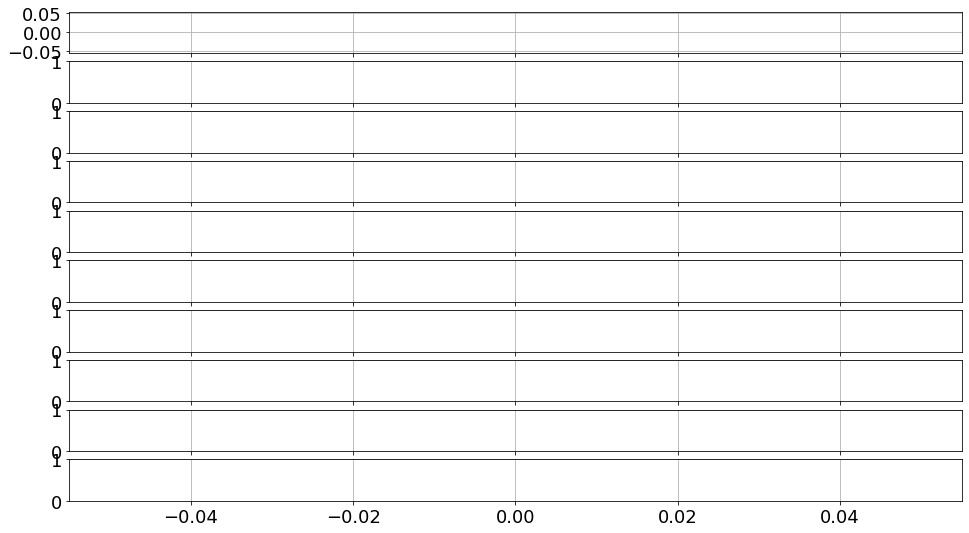

: 

In [ ]:
rcParams['axes.grid'] = True
rcParams['font.size'] = 18
fig, ax, graphics = do_mpc.graphics.default_plot(mpc.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()
plt.show()

##### Path Callback Function

In [ ]:
def path_callback(path):

    path_repeat = False
    
    ##################################
    # Step1 - Obtaining the path points
    ##################################
    
    l = len(path.poses)                # length of the path
    points = np.zeros((l,2))           # array for storing the path points
    if not path_repeat:    
        for j in range(l):
            points[j][0] = path.poses[j].pose.position.y
            points[j][1] = path.poses[j].pose.position.x
            path_points.append([path.poses[j].pose.position.y, path.poses[j].pose.position.x])


    ###########################
    # Step2 - Interplotate
    ###########################


    lin_val_x(points[:,1])
    lin_val_y(points[:,0])

    
    u0 = mpc.make_step(x_0)    # Determine optimal control inputs using the inital state given

    # publish the steering angle and acceleration and brake values 
    if u0[0][0]>=0:
        acc_pub.publish(u0[0][0]/6)
    else:
        force = u0[0][0] * m
        torque = -0.32 * force
        brake_pub.publish(torque)

    steer += u0[1][0] * t_s
    steer_pub.publish(steer*17)
    gear_pub.publish(0)

    y_n = simulator.make_step(u0)					# Simulate the next step using the control inputs
    x_0 = estimator.make_step(y_n)			    # estimate the next state

    z_sim = y_n[5]

: 

##### State Callback function

In [ ]:
def state_callback(state):
    # get the state 
    # update the class variable for curent state value
    
    ######################################
    # Step1 - Obtaining the state vector
    ######################################

    pose_arr = []
    twist_arr = [] 

    pose_arr.append(state.pose[-1].position.x)
    pose_arr.append(state.pose[-1].position.y)

    twist_arr.append(state.twist[-1].linear.x)
    twist_arr.append(state.twist[-1].linear.y)
    twist_arr.append(state.twist[-1].angular.z)

    ####################################
    # Step2 - Update the function handles
    ####################################

    x_0 = np.vstack((  
        [pose_arr[0]],
        [pose_arr[1]],
        [float(np.sqrt(twist_arr[0]**2 + twist_arr[1]**2))],
        [float(np.arctan(twist_arr[1]/(twist_arr[0]+(1e-50))))],
        [float(twist_arr[2])],
        [self.steer],
        [self.z_sim]
        ))

: 

##### Velocity Callback Function

In [ ]:
def vel_callback(vel_arr):

	velocities.append(vel_arr.data[0])
	
	######################################
	# Step1 - Obtaining the velocity points
	######################################

	l = len(vel_arr.data)
	vel = np.zeros((l, 1))
	for i in range(l):
		vel[i][0] = vel_arr.data[i] 

	###########################
	# Step2 - Interplotate
	###########################

	# interpolation using the indices as the variable.
	lin_val_v(vel)

	####################################
	# Step3 - Update the function handles
	####################################

	set_vel(v_z)

: 

##### Steer Callback Function

In [ ]:
def steer_callback(steer):
    # get the state 
    # update the class variable for curent state value

    ####################################
    # Step1 - Update the function handles
    ####################################

    steer_0 = steer

: 

##### Running the entire Model

In [ ]:
# run the control loop
rospy.spin()

: 